> <center><h2>Identifying mental health disorders Artificial Intelligence using Natural Language Processing & Deep Learning Techniques</h2>
> <br><h3>Zacharias Siatris</h3>
> <h3>MSc in Artificial Intelligence
    The University of Bath<br>2022 - 2023</h3></center><br>

### Import Dependencies

- [nltk](https://www.nltk.org/) - library for using work tokenization and pos tagging
- [tensorflow](https://www.tensorflow.org/) - library for using keras' functionalities for the Deep Learning model
- [transformers](https://huggingface.co/docs/transformers/v4.17.0/en/index) - Transformers provides APIs and tools and is utilized for the NLP Model (Validation) 
- [wordcloud](https://pypi.org/project/wordcloud/) - Scikit-Learn compatible wrappers for Keras Models to generate word clouds
- [packaging](https://pypi.org/project/packaging/) - library for version handling and correcting warning messages
- [pandas](https://pandas.pydata.org/) - library for loading and displaying the data in a table
- [numpy](http://www.numpy.org/) - library that we will use for linear algebra operations
- [matplotlib](https://matplotlib.org/) - library that we will use for plotting the data
- [seaborn](https://seaborn.pydata.org/) - library for data visualizations

In [1]:
!pip install nltk
!pip install tensorflow
!pip install transformers
!pip install wordcloud
!pip install packaging


import time
import pandas as pd
import nltk
import re, string
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from transformers import pipeline

from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import OrderedDict
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZachariasSiatris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZachariasSiatris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ZachariasSiatris\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZachariasSiatris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ZachariasSiatris\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

> Initializing the variables that will be later used for reporting and model-utilization purposes

- **`load_big_datasets`**: This boolean variable when set to 'True' will use the csv files that include more than 800K samples. 
<br><b><u>Warning:</u></b> Depending the machine you are executing this notebook it may take from 1-3 hours.


- **`use_nlp_validation_model`**: This boolean variable when set to 'True' will utilize the NLP validation model (Hugging Face) in order to apply sentiment analysis to the dataset. 
<br><b><u>Warning:</u></b> It requires a lot of time due to the use of API calls. In case you selected to load the big datasets, **<font color=#FF0000>make sure you set this variable to 'False' </font>**.


- **`print_word_cloud_per_disorder`**: This boolean variable when set to 'True' will print at the last section "Results & Visualizations" a bag of words included in each mental health disorder using Word Cloud.


- **`print_dataset_each_step`**: This boolean variable when set to 'True' will print the dataframe object at each step during the NLP development.


- **`number_of_rows_to_print`**: This number regards to the "print_dataset_each_step" variable and sets the number of rows of the dataframe object to be printed on each step. 

In [2]:
pd.set_option('display.colheader_justify', 'center')
pd.options.display.max_columns = None
np.set_printoptions(suppress=True)

english_stop_words = stopwords.words('english')
 

load_big_datasets = True    
use_nlp_validation_model = False


print_word_cloud_per_disorder = True
print_dataset_each_step = True
number_of_rows_to_print = 10

> <br><br><center><h1>Mental Health Disorder Datasets</h1><br><br>

In [3]:
if load_big_datasets:
    files = 'CSV_Files_Large_Datasets'
else:
    files = 'CSV_Files_Small_Datasets'


bpd_dataframe = pd.read_csv('Datasets/' + files + '/BPD_Disorder_Dataset.csv')
anxiety_dataframe = pd.read_csv('Datasets/' + files + '/Anxiety_Disorder_Dataset.csv')
bipolar_dataframe = pd.read_csv('Datasets/' + files + '/Bipolar_Disorder_Dataset.csv')
depression_dataframe = pd.read_csv('Datasets/' + files + '/Depression_Disorder_Dataset.csv')
eating_dataframe = pd.read_csv('Datasets/' + files + '/Eating_Disorder_Dataset.csv')
general_dataframe = pd.read_csv('Datasets/' + files + '/General_Mental_Disorder_Dataset.csv')
schizophrenia_dataframe = pd.read_csv('Datasets/' + files + '/Schizophrenia_Disorder_Dataset.csv')
gender_dataframe = pd.read_csv('Datasets/' + files + '/Gender_Dysphoria_Disorder_Dataset.csv')


# Merging dataframes
merged_dataframes = [bpd_dataframe, 
                     anxiety_dataframe, 
                     bipolar_dataframe,
                     depression_dataframe, 
                     eating_dataframe, 
                     general_dataframe, 
                     schizophrenia_dataframe, 
                     gender_dataframe]

# Resetting the index of the consolidated dataset
merged_dataframes = pd.concat(merged_dataframes).reset_index(drop=True)

# Copying dataset to show comparison results and reports later in this notebook
before_process_merged_dataframes = merged_dataframes.copy()

# Removing samples where values are empty
merged_dataframes = merged_dataframes.dropna()

> <br><br><center><h1>Natural Language Processing (Validation Model)</h1><br><br>

In [4]:
def validation_nlp(dataframe):
    
    # This is the NLP model that is is used for sentiment analysis (validation). If the "use_nlp_validation" is set to True
    # it will execute the code, else it will move on to the last line to return the dataframe as it was
    if use_nlp_validation_model:
        
        print('\n\n\033[1m' + 'Validation NLP Model (Sentiment Analysis) has been initiated'+ '\033[0m\n')
        
        # Creating the classifier and setting the parameter for sentiment analysis
        classifier = pipeline("sentiment-analysis")
        
        # A new column "sentiment" is created as soon as the sentiment is retrieved
        # The "get('label')" returns the list of the values (POSITIVE, NEGATIVE)
        # The reason "max_length" is set to 512 is because of the limitation this specific classifier has
        dataframe['sentiment'] = [classifier(' '.join(row), max_length=512)[0].get('label') for row in dataframe['text']]

        # Removing rows from the dataset where the sentiment analysis is positive
        dataframe.drop(dataframe[(dataframe['sentiment'] == 'POSITIVE')].index, inplace=True)
        
        print_dataset(dataframe) 
    
    return dataframe

> <br><br><center><h1>Natural Language Processing (Implementation Model)</h1><br><br>

In [5]:
# Method to remove contractions
def removing_contractions(line):
    
    # lines with special character (’)
    line = line.replace("’", "'")
    
    # Replacing abbreviations for mental health disorders
    line = re.sub("aspd", "antisocial personality disorder", line)
    line = re.sub("adhd", "attention deficit hyperactivitydisorder ", line)
    line = re.sub("avpd", "avoidant personality disorder", line)
    line = re.sub("bdd", "body dysmorphic disorder", line)
    line = re.sub("bpd", "borderline personality disorder", line)
    line = re.sub("crsd", "circadian rhythm sleep disorder", line)
    line = re.sub("ednos", "eating disorder not otherwise specified", line)
    line = re.sub(" gad ", " generalized anxiety disorder ", line)
    line = re.sub(" nes ", " night eating syndrome ", line)
    line = re.sub("mdd", "major depressive disorder", line)
    line = re.sub("ocd", "obsessive-compulsive disorder", line)
    line = re.sub("ppd", "paranoid personality disorder", line)
    line = re.sub(" pted ", " post traumatic embitterment disorder ", line)
    line = re.sub("ptsd", "post traumatic stress disorder", line)
    line = re.sub(" sza ", " schizoaffective disorder ", line)
    line = re.sub("spd", "schizoid personality disorder", line)


    # Replacing top slang words related to psychological-oriented tweets, posts, etc.
    line = re.sub(" imma ", " I am going to ", line)
    line = re.sub(" wanna ", " I want to ", line)
    line = re.sub(" lemme ", " let me ", line)
    line = re.sub(" kinda ", " kind of ", line)
    line = re.sub(" init ", " is not it ", line)
    line = re.sub(" gotta ", " got to ", line)
    line = re.sub(" gonna ", " going to ", line)
    line = re.sub(" gona ", " going to ", line)
    line = re.sub(" gimme ", " give me ", line)
    line = re.sub(" yr ", " year ", line)
    line = re.sub(" yrs ", " years ", line)
    line = re.sub(" bc ", " because ", line)
    line = re.sub(" cuz ", " because ", line)
    line = re.sub("idk", "I do not know", line)
    line = re.sub(" bf ", " boyfriend ", line)
    line = re.sub(" gf ", " girlfriend ", line)
    line = re.sub(" dae ", " does anybody else ", line)
    line = re.sub(" fp ", " favourite person ", line)


    # Replacing abbreviations in English language
    line = re.sub(r"ain't", "is not", line)
    line = re.sub(r"aren't", "are not", line)
    line = re.sub(" arent ", " are not ", line)
    line = re.sub(r"can't", "cannot", line)
    line = re.sub(" cant ", " cannot ", line)
    line = re.sub(r"can't've", "cannot have", line)
    line = re.sub(" cause ", "because", line)
    line = re.sub(r"could've", "could have", line)
    line = re.sub(r"couldn't", "could not", line)
    line = re.sub(" couldnt ", " could not ", line)
    line = re.sub(r"couldn't've", "could not have", line)
    line = re.sub(r"didn't", "did not", line)
    line = re.sub(" didnt ", " did not ", line)
    line = re.sub(r"doesn't", "does not", line)
    line = re.sub(" doesnt ", " does not ", line)
    line = re.sub(r"don't", "do not", line)
    line = re.sub(" dont ", " do not ", line)
    line = re.sub(r"hadn't", "had not", line)
    line = re.sub(" hadnt ", " had not ", line)
    line = re.sub(r"hadn't've", "had not have", line)
    line = re.sub(r"hasn't", "has not", line)
    line = re.sub(" hasnt ", " has not ", line)
    line = re.sub(r"haven't", "have not", line)
    line = re.sub(" havent ", " have not ", line)
    line = re.sub(r"he'd", "he would", line)
    line = re.sub(r"he'd've", "he would have", line)
    line = re.sub(r"he'll", "he will", line)
    line = re.sub(r"he'll've", "he he will have", line)
    line = re.sub(r"he's", "he is", line)
    line = re.sub(r"how'd", "how did", line)
    line = re.sub(r"how'd'y", "how do you", line)
    line = re.sub(r"how'll", "how will", line)
    line = re.sub(r"how's", "how is", line)
    line = re.sub(" hows ", " how is ", line)
    line = re.sub(r"i'd", "i would", line)
    line = re.sub(r"i'd've", "i would have", line)
    line = re.sub(r"i'll", "i will", line)
    line = re.sub(r"i'll've", "i will have", line)
    line = re.sub(r"i'm", "i am", line)
    line = re.sub(" im ", " i am ", line)
    line = re.sub(r"i've", "i have", line)
    line = re.sub(" ive ", " i have ", line)
    line = re.sub(r"isn't", "is not", line)
    line = re.sub(" isnt ", " is not ", line)
    line = re.sub(r"it'd", "it would", line)
    line = re.sub(r"it'd've", "it would have", line)
    line = re.sub(r"it'll", "it will", line)
    line = re.sub(r"it'll've", "it will have", line)
    line = re.sub(r"it's", "it is", line)
    line = re.sub(r"let's", "let us", line)
    line = re.sub(" lets ", " let us ", line)
    line = re.sub(r"ma'am", "madam", line)
    line = re.sub(r"mayn't", "may not", line)
    line = re.sub(r"might've", "might have", line)
    line = re.sub(r"mightn't", "might not", line)
    line = re.sub(r"mightn't've", "might not have", line)
    line = re.sub(r"must've", "must have", line)
    line = re.sub(r"mustn't", "must not", line)
    line = re.sub(" mustnt ", " must not ", line)
    line = re.sub(r"mustn't've", "must not have", line)
    line = re.sub(r"needn't", "need not", line)
    line = re.sub(" neednt ", " need not ", line)
    line = re.sub(r"needn't've", "need not have", line)
    line = re.sub("no where", "nowhere", line)
    line = re.sub(r"o'clock", "of the clock", line)
    line = re.sub("oclock", "of the clock", line)
    line = re.sub(r"oughtn't", "ought not", line)
    line = re.sub(r"oughtn't've", "ought not have", line)
    line = re.sub(r"shan't", "shall not", line)
    line = re.sub(r"sha'n't", "shall not", line)
    line = re.sub(r"shan't've", "shall not have", line)
    line = re.sub(r"she'd", "she would", line)
    line = re.sub(r"she'd've", "she would have", line)
    line = re.sub(r"she'll", "she will", line)
    line = re.sub(r"she'll've", "she will have", line)
    line = re.sub(r"she's", "she is", line)
    line = re.sub(r"should've", "should have", line)
    line = re.sub(r"shouldn't", "should not", line)
    line = re.sub(" shouldnt ", " should not ", line)
    line = re.sub(r"shouldn't've", "should not have", line)
    line = re.sub(r"so've", "so have", line)
    line = re.sub(r"so's", "so as", line)
    line = re.sub(r"that'd", "that would", line)
    line = re.sub(r"that'd've", "that would have", line)
    line = re.sub(r"that's", "that is", line)
    line = re.sub(" thats ", " that is ", line)
    line = re.sub(r"there'd", "there would", line)
    line = re.sub(r"there'd've", "there would have", line)
    line = re.sub(r"there's", "there is", line)
    line = re.sub(" theres ", "there is", line)
    line = re.sub(r"they'd", "they would", line)
    line = re.sub(r"they'd've", "they would have", line)
    line = re.sub(r"they'll", "they will", line)
    line = re.sub(r"they'll've", "they will have", line)
    line = re.sub(r"they're", "they are", line)
    line = re.sub(r"they've", "they have", line)
    line = re.sub(r"to've", "to have", line)
    line = re.sub(r"wasn't", "was not", line)
    line = re.sub(" wasnt ", " was not ", line)
    line = re.sub(r"we'd", "we would", line)
    line = re.sub(r"we'd've", "we would have", line)
    line = re.sub(r"we'll", "we will", line)
    line = re.sub(r"we'll've", "we will have", line)
    line = re.sub(r"we're", "we are", line)
    line = re.sub(r"we've", "we have", line)
    line = re.sub(r"weren't", "were not", line)
    line = re.sub(r" werent ", " were not ", line)
    line = re.sub(r"what'll", "what will", line)
    line = re.sub(r"what'll've", "what will have", line)
    line = re.sub(r"what're", "what are", line)
    line = re.sub(r"what's", "what is", line)
    line = re.sub(r" whats ", " what is ", line)
    line = re.sub(r"what've", "what have", line)
    line = re.sub(r"when's", "when is", line)
    line = re.sub(r"when've", "when have", line)
    line = re.sub(r"where'd", "where did", line)
    line = re.sub(r"where's", "where is", line)
    line = re.sub(r"where've", "where have", line)
    line = re.sub(r"who'll", "who will", line)
    line = re.sub(r"who'll've", "who will have", line)
    line = re.sub(r"who's", "who is", line)
    line = re.sub(r"who've", "who have", line)
    line = re.sub(r"why's", "why is", line)
    line = re.sub(r"why've", "why have", line)
    line = re.sub(r"will've", "will have", line)
    line = re.sub(r"won't", "will not", line)
    line = re.sub(" wont ", " will not ", line)
    line = re.sub(r"won't've", "will not have", line)
    line = re.sub(r"would've", "would have", line)
    line = re.sub(r"wouldn't", "would not", line)
    line = re.sub(r" wouldnt ", " would not ", line)
    line = re.sub(r"wouldn't've", "would not have", line)
    line = re.sub(r"y'all", "you all", line)
    line = re.sub(r"y'all'd", "you all would", line)
    line = re.sub(r"y'all'd've", "you all would have", line)
    line = re.sub(r"y'all're", "you all are", line)
    line = re.sub(r"y'all've", "you all have", line)
    line = re.sub(r"you'd", "you would", line)
    line = re.sub(r"you'd've", "you would have", line)
    line = re.sub(r"you'll", "you will", line)
    line = re.sub(r"you'll've", "you will have", line)
    line = re.sub(r"you're", "you are", line)
    line = re.sub(r" youre ", " you are ", line)
    line = re.sub(r"you've", "you have", line)
    line = re.sub("etc", " ", line)

    return line



# function to remove non-ASCII
def remove_non_ascii(text):
    return ''.join(char for char in text if ord(char) < 128)



# Method to clear out rows with empty cells, replace non-ASCII characters and remove contractions
def pre_processing_data(dataframe):
    # Deleting rows from the dataset where rows are empty
    dataframe = dataframe.dropna()

    # Deleting duplicate rows from the dataset
    dataframe = dataframe.drop_duplicates()
    
    # Converts uppercase characters to lowercase
    dataframe['text'] = dataframe['text'].str.lower()
    
    # Replacing contractions to original words
    dataframe['text'] = dataframe['text'].apply(removing_contractions)

    # Applying ASCII encoding first flagging data with errors="ignore" flag, then subsequently decoding it into ASCII
    dataframe['text'] = dataframe['text'].apply(remove_non_ascii)

    # Removing newline characters
    dataframe['text'] = dataframe['text'].replace(r'\n', ' ', regex=True)

    # Removing the character reference "An ampersand"
    dataframe['text'] = dataframe['text'].replace('&amp;', ' ', regex=True)

    return dataframe



# Method to tokenize the text into tokens (words)
def tokenize_dataframe(dataframe):
    for index, row in dataframe.iterrows():
        row['text'] = nltk.word_tokenize(row['text'])

    return dataframe



# Method to lemmatize each word in the text column of the dataframe
def lemmatize_sentence(dataframe):
    lemmatizer = WordNetLemmatizer()

    for index, row in dataframe.iterrows():
        lemmatized_phrase = []

        for word, tag in pos_tag(row['text']):
            if tag.startswith('NN'):
                pos = 'n'
            elif tag.startswith('VB'):
                pos = 'v'
            else:
                pos = 'a'
            lemmatized_phrase.append(lemmatizer.lemmatize(word, pos))
            
        dataframe.at[index, 'text'] = " ".join(lemmatized_phrase)

    return dataframe



# Method to remove emoticons, flags and special characters
def remove_emojis(line):
    emoj = re.compile("["
                      u"\U0001F600-\U0001F64F"  # emoticons
                      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                      u"\U0001F680-\U0001F6FF"  # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                      u"\U00002500-\U00002BEF"  # chinese char
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      u"\U0001f926-\U0001f937"
                      u"\U00010000-\U0010ffff"
                      u"\u2640-\u2642"
                      u"\u2600-\u2B55"
                      u"\u200d"
                      u"\u23cf"
                      u"\u23e9"
                      u"\u231a"
                      u"\ufe0f"
                      u"\u3030"
                      "]+", re.UNICODE)

    return re.sub(emoj, '', line)



# Method to remove noise from the data (meaning: stop words, emojis and special characters, urls, etc.)
def remove_noise(dataframe, stop_words):
    dataframe['text'] = dataframe['text'].str.replace('\d+', '', regex=True)
    dataframe['text'] = dataframe['text'].str.replace('\W', ' ', regex=True)
    dataframe['text'] = dataframe['text'].apply(lambda x: re.split('http.*', str(x))[0])
    
    for index, row in dataframe.iterrows():
        cleaned_phrase = []

        for word in row['text'].split():
            word = re.sub('(@[A-Za-z0-9_]+)', '', word)
            word = remove_emojis(word)

            if len(word) >= 1 and word not in string.punctuation and word not in stop_words:
                cleaned_phrase.append(word)

        dataframe.at[index, 'text'] = " ".join(cleaned_phrase)

    return dataframe



# Method to unify words into text and remove duplicates. 
# Also it removes rows that have only few words as context (using 15 as minimum threshold)
def remove_rows_with_few_words(dataframe):
    dataframe['text'] = (dataframe['text'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))
    dataframe = dataframe.loc[dataframe['text'].str.count(' ').gt(15)]
    
    return dataframe



# TfidfVectorizer
def create_tfidf_model(dataframe):
    tfidf_vectorizer = TfidfVectorizer(min_df=0.02, max_df=0.98, ngram_range=(1, 2), stop_words='english')
    samples = dataframe['text']
    labels = dataframe['mental_health_disorder']

    samples_for_train, samples_for_test, labels_for_train, labels_for_test = train_test_split(samples,
                                                                                              labels,
                                                                                              test_size=0.1,
                                                                                              shuffle=True)

    samples_for_train_vectorized = tfidf_vectorizer.fit_transform(samples_for_train).todense()
    samples_for_test_vectorized = tfidf_vectorizer.transform(samples_for_test).todense()

    tfidf_vectorizer.labels_for_train = labels_for_train
    tfidf_vectorizer.labels_for_test = labels_for_test

    tfidf_vectorizer.samples_for_train = samples_for_train
    tfidf_vectorizer.samples_for_test = samples_for_test

    tfidf_vectorizer.samples_for_train_vectorized = samples_for_train_vectorized
    tfidf_vectorizer.samples_for_test_vectorized = samples_for_test_vectorized
    
    tfidf_vectorizer.processed_dataframe = dataframe

    return tfidf_vectorizer



def print_dataset(dataframe):
    if print_dataset_each_step:
        print("Printing first " + str(number_of_rows_to_print) + " rows of the dataframe:\n")
        display(dataframe.head(number_of_rows_to_print))

<br><br>Below you may find the method that includes and consolidates all the NLP processing steps into one for developing the NLP model

In [6]:
def initiate_nlp(dataframe):
    
    print('\n\n\033[1m' + 'Main NLP Model has been initiated'+ '\033[0m\n')
    print_dataset(dataframe)

    
    # Starting with the first method for processing the data (STEP 1)
    print("\n  - STEP 1 STARTED: Pre-processing dataset\n")
    dataframe = pre_processing_data(dataframe)
    print_dataset(dataframe)
    
    
    # Tokenizing the data (STEP 2)
    print("\n\n  - STEP 2 STARTED: Tokenizing dataset\n")
    dataframe = tokenize_dataframe(dataframe)
    print_dataset(dataframe)
    

    # Lemmatizing the data of the dataframe (STEP 3)
    print("\n\n  - STEP 3 STARTED: Lemmatizing dataset\n")
    dataframe = lemmatize_sentence(dataframe)
    print_dataset(dataframe)
    

    # Removing noise (STEP 4)
    print("\n\n  - STEP 4 STARTED: Removing noise from the dataset\n")
    dataframe = remove_noise(dataframe, english_stop_words)
    print_dataset(dataframe)
    

    # Deleting rows after the processing where cells are empty (if any)
    dataframe = dataframe.dropna()
    
    
    # Removing rows with few words as context (STEP 5)
    print("\n\n  - STEP 5 STARTED: Removing rows with few words from the dataset\n")
    dataframe = remove_rows_with_few_words(dataframe)
    print_dataset(dataframe)   
    
    
    # Removing rows with few words as context (STEP 6)
    print("\n\n  - STEP 6 STARTED: Term Frequency-Inverse Document Frequency\n\n\n")
    tfidf_vectorizer = create_tfidf_model(dataframe)
    print_dataset(dataframe)

    return tfidf_vectorizer

> <br><br><center><h1>Deep Learning Model</h1><br><br>

This is the place where you might want to play with model configuration. Be aware though that the training of the neural network with current parameters may take up to 15 minutes depending on the hardware. 

- **`random.seed`**:  This seed generator is used to make sure that the same sequences of numbers will be allocated and therefore, achieve reproducibility.
- **`number_of_classes`**: This parameter represents the total number of unique classes (or labels) of the dataset. It is dynamic; meaning it gets automatically the unique number of the mental health labels of the consolidated datasets. By doing this, the LabelEncoder method creates the relevant numerical values for each categorigal mental health label.
- **`batch_size`**: This parameter defines the volume of data that will be propagated through the deep learning network.
- **`number_of_epochs`**: This parameter sets the number of complete passes through the training dataset. In other words, it is the number of one forward pass and one backward pass of the training dataset.

In [7]:
# Parameters for Deep Learning Model
np.random.seed(0)
number_of_classes = len(merged_dataframes["mental_health_disorder"].unique())
batch_size = 64
number_of_epochs = 20
    

# Method for building the Deep Learning Model
def build_deep_learning_model():
    
    model = Sequential()
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(number_of_classes))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model



# Converting probabilities to labels based on threshold
def convert_probabilities_to_labels(dataset, encoder):
    
    labelled_dataset = []
    for row in dataset:
        length_row = len(row)
        temporary = [i for i in range(length_row) if row[i] >= 0.1]
        temporary_2 = [encoder.classes_[i] for i in temporary]
        labelled_dataset.append(temporary_2)

    return labelled_dataset



# Method for testing the Deep Learning Model
def test_deep_learning_model(samples_for_train, samples_for_test, labels_for_train, labels_for_test,
                             deep_learning_model, label_encoder):
    
    # Predicting mental health labels for both training and testing datasets
    train_predictions = deep_learning_model.predict(samples_for_train, batch_size)
    test_predictions = deep_learning_model.predict(samples_for_test, batch_size)

    # Converting probabilities to labels based on threshold:
    train_labelled_predictions = convert_probabilities_to_labels(train_predictions, label_encoder)
    test_labelled_predictions = convert_probabilities_to_labels(test_predictions, label_encoder)

    # From the list of the predictions argmax is used to get the label(index) with the highest probability. This way
    # a comparison between this and the real label takes place to calculate the accuracy.
    train_predicted_max_values = np.argmax(train_predictions, axis=1)
    test_predicted_max_values = np.argmax(test_predictions, axis=1)

    # The for-loop is used to convert the indexed values to the real categorical label (text) from the list of classes (labels)
    train_predicted_max_values = [label_encoder.classes_[i] for i in train_predicted_max_values]
    test_predicted_max_values = [label_encoder.classes_[i] for i in test_predicted_max_values]

    # Storing results to variables to be able to visualize and report them later in this notebook
    train_score = round(accuracy_score(labels_for_train, train_predicted_max_values), 4)
    train_report = classification_report(labels_for_train, train_predicted_max_values)

    test_score = round(accuracy_score(labels_for_test, test_predicted_max_values), 4)
    test_report = classification_report(labels_for_test, test_predicted_max_values)

    results = train_score, train_report, test_score, test_report, train_labelled_predictions, test_labelled_predictions

    return results

<br><br>Below you may find the method that includes and consolidates all the steps into one for developing the Deep Learning model:

In [8]:
def initiate_deep_learning(tfidf_vectorizer):
    
    print('\n\n\033[1m' + 'Deep Learning Model has been initiated'+ '\033[0m\n')
    
    # LabelEncoder method is used to convert categorical values (labels) to numerical ones
    label_encoder = LabelEncoder()
    label_encoder.fit(tfidf_vectorizer.labels_for_train)
    encoded_labels_for_train = label_encoder.transform(tfidf_vectorizer.labels_for_train)

    # The method "to_categorical" is used to convert the numerical values to binary matrix (similar to One-Hot Encoding)
    binary_labels_for_train = np_utils.to_categorical(encoded_labels_for_train, number_of_classes)

    # Building Deep Learning Model
    deep_learning_model = build_deep_learning_model()

    # Training Deep Learning Model
    # The variable "model_history" is used to save the results of the training performance and for reporting purposes
    model_history = deep_learning_model.fit(tfidf_vectorizer.samples_for_train_vectorized,
                                            binary_labels_for_train,
                                            batch_size,
                                            number_of_epochs,
                                            verbose=1)

    # Creating predictions and testing Deep Learning Model
    results = test_deep_learning_model(tfidf_vectorizer.samples_for_train_vectorized,
                                       tfidf_vectorizer.samples_for_test_vectorized,
                                       tfidf_vectorizer.labels_for_train,
                                       tfidf_vectorizer.labels_for_test,
                                       deep_learning_model,
                                       label_encoder)

    return model_history, results

<br><br>Below you may find the main method that includes the following steps:

- Developing the first NLP model (Validation Model)
- Developing the second NLP model (Implementation Model)
- Developing the Deep Learning model (Multi-class Classification)

In [9]:
########################
start_time = time.time()
########################


merged_dataframes = validation_nlp(merged_dataframes)

tfidf_vectorizer = initiate_nlp(merged_dataframes)

model_history, results = initiate_deep_learning(tfidf_vectorizer)


########################
end_time = time.time()
########################



Main NLP Model has been initiated

Printing first 20 rows of the dataframe:



text                        mental_health_disorder
0   Does anyone else think the most important part...      bpd_disorder     
1   Hello fellow friends 😄\n\nI'm on the BPD spect...      bpd_disorder     
2   My [F20] bf [M20] told me today (after I said ...      bpd_disorder     
3   Okay, I’m about to open up about many things I...      bpd_disorder     
4   Without going into detail, this diagnosis expl...      bpd_disorder     
5   (Reposting here on the larger sub on recommend...      bpd_disorder     
6   I grew up mostly dating men but realized when ...      bpd_disorder     
7   I posted on this sub earlier today about havin...      bpd_disorder     
8   If they were to tell you that you were being o...      bpd_disorder     
9   I am in a really dark moment in my life right ...      bpd_disorder     
10  My appointment with my therapist last week end...      bpd_disorder     
11  Hi guys whenever I get overwhelmed and find my...      bpd_disorder     
12  I have been actually feeling positive most of ...      bpd_disorder     
13  So within the past couple months ive came to t...      bpd_disorder     
14  Two days ago I posted something so cute about ...      bpd_disorder     
15  it fucking hurts\n\nit hurts it hurts it hurts...      bpd_disorder     
16  Is it overcompensating because you feel unwort...      bpd_disorder     
17  the other day my ex questioned if i actually l...      bpd_disorder     
18  idk what to do here and could really use some ...      bpd_disorder     
19  Does anyone else feel weird about birthdays ev...      bpd_disorder

I am in a really dark moment in my life right now. My husband is a controlling pos that believes he’s a doctor and doesn’t allow me to get any kind of treatment for my BPD. I recently moved to his country and I am unable to do anything by myself (I don’t speak Korean), also he keeps the salary of my job so I don’t have money. I can’t move back to my country either, my family stopped to talk to me because I married him, so how can I cope with all the suicide thoughts I have everyday? I also suffer from anger management issues and without medicine, I can’t control myself and we fight a lot. I feel really lonely here, he works 24/7, but I prefer that than being with him honestly. He’s controlling and even violent sometimes. What do you recommend to treat my BPD?

  - STEP 1 STARTED: Pre-processing dataset

Printing first 20 rows of the dataframe:



text                        mental_health_disorder
0   does anyone else think the most important part...      bpd_disorder     
1   hello fellow friends   i am on the  borderline...      bpd_disorder     
2   my [f20] boyfriend [m20] told me today (after ...      bpd_disorder     
3   okay, i am about to open up about many things ...      bpd_disorder     
4   without going into detail, this diagnosis expl...      bpd_disorder     
5   (reposting here on the larger sub on recommend...      bpd_disorder     
6   i grew up mostly dating men but realized when ...      bpd_disorder     
7   i posted on this sub earlier today about havin...      bpd_disorder     
8   if they were to tell you that you were being o...      bpd_disorder     
9   i am in a really dark moment in my life right ...      bpd_disorder     
10  my appointment with my therapist last week end...      bpd_disorder     
11  hi guys whenever i get overwhelmed and find my...      bpd_disorder     
12  i have been actually feeling positive most of ...      bpd_disorder     
13  so within the past couple months i have came t...      bpd_disorder     
14  two days ago i posted something so cute about ...      bpd_disorder     
15  it fucking hurts  it hurts it hurts it hurts i...      bpd_disorder     
16  is it overcompensating because you feel unwort...      bpd_disorder     
17  the other day my ex questioned if i actually l...      bpd_disorder     
18   I do not know  what to do here and could real...      bpd_disorder     
19  does anyone else feel weird about birthdays ev...      bpd_disorder

i am in a really dark moment in my life right now. my husband is a controlling pos that believes he is a doctor and does not allow me to get any kind of treatment for my  borderline personality disorder . i recently moved to his country and i am unable to do anything by myself (i do not speak korean), also he keeps the salary of my job so i do not have money. i cannot move back to my country either, my family stopped to talk to me because i married him, so how can i cope with all the suicide thoughts i have everyday? i also suffer from anger management issues and without medicine, i cannot control myself and we fight a lot. i feel really lonely here, he works 24/7, but i prefer that than being with him honestly. he is controlling and even violent sometimes. what do you recommend to treat my  borderline personality disorder ?


  - STEP 2 STARTED: Tokenizing dataset

Printing first 20 rows of the dataframe:



text                        mental_health_disorder
0   [does, anyone, else, think, the, most, importa...      bpd_disorder     
1   [hello, fellow, friends, i, am, on, the, borde...      bpd_disorder     
2   [my, [, f20, ], boyfriend, [, m20, ], told, me...      bpd_disorder     
3   [okay, ,, i, am, about, to, open, up, about, m...      bpd_disorder     
4   [without, going, into, detail, ,, this, diagno...      bpd_disorder     
5   [(, reposting, here, on, the, larger, sub, on,...      bpd_disorder     
6   [i, grew, up, mostly, dating, men, but, realiz...      bpd_disorder     
7   [i, posted, on, this, sub, earlier, today, abo...      bpd_disorder     
8   [if, they, were, to, tell, you, that, you, wer...      bpd_disorder     
9   [i, am, in, a, really, dark, moment, in, my, l...      bpd_disorder     
10  [my, appointment, with, my, therapist, last, w...      bpd_disorder     
11  [hi, guys, whenever, i, get, overwhelmed, and,...      bpd_disorder     
12  [i, have, been, actually, feeling, positive, m...      bpd_disorder     
13  [so, within, the, past, couple, months, i, hav...      bpd_disorder     
14  [two, days, ago, i, posted, something, so, cut...      bpd_disorder     
15  [it, fucking, hurts, it, hurts, it, hurts, it,...      bpd_disorder     
16  [is, it, overcompensating, because, you, feel,...      bpd_disorder     
17  [the, other, day, my, ex, questioned, if, i, a...      bpd_disorder     
18  [I, do, not, know, what, to, do, here, and, co...      bpd_disorder     
19  [does, anyone, else, feel, weird, about, birth...      bpd_disorder

['i', 'am', 'in', 'a', 'really', 'dark', 'moment', 'in', 'my', 'life', 'right', 'now', '.', 'my', 'husband', 'is', 'a', 'controlling', 'pos', 'that', 'believes', 'he', 'is', 'a', 'doctor', 'and', 'does', 'not', 'allow', 'me', 'to', 'get', 'any', 'kind', 'of', 'treatment', 'for', 'my', 'borderline', 'personality', 'disorder', '.', 'i', 'recently', 'moved', 'to', 'his', 'country', 'and', 'i', 'am', 'unable', 'to', 'do', 'anything', 'by', 'myself', '(', 'i', 'do', 'not', 'speak', 'korean', ')', ',', 'also', 'he', 'keeps', 'the', 'salary', 'of', 'my', 'job', 'so', 'i', 'do', 'not', 'have', 'money', '.', 'i', 'can', 'not', 'move', 'back', 'to', 'my', 'country', 'either', ',', 'my', 'family', 'stopped', 'to', 'talk', 'to', 'me', 'because', 'i', 'married', 'him', ',', 'so', 'how', 'can', 'i', 'cope', 'with', 'all', 'the', 'suicide', 'thoughts', 'i', 'have', 'everyday', '?', 'i', 'also', 'suffer', 'from', 'anger', 'management', 'issues', 'and', 'without', 'medicine', ',', 'i', 'can', 'not', 'c

text                        mental_health_disorder
0   do anyone else think the most important part o...      bpd_disorder     
1   hello fellow friend i be on the borderline per...      bpd_disorder     
2   my [ f20 ] boyfriend [ m20 ] tell me today ( a...      bpd_disorder     
3   okay , i be about to open up about many thing ...      bpd_disorder     
4   without go into detail , this diagnosis explai...      bpd_disorder     
5   ( reposting here on the large sub on recommend...      bpd_disorder     
6   i grow up mostly date men but realize when i b...      bpd_disorder     
7   i post on this sub early today about have trou...      bpd_disorder     
8   if they be to tell you that you be be overdram...      bpd_disorder     
9   i be in a really dark moment in my life right ...      bpd_disorder     
10  my appointment with my therapist last week end...      bpd_disorder     
11  hi guy whenever i get overwhelm and find mysel...      bpd_disorder     
12  i have be actually feel positive most of the t...      bpd_disorder     
13  so within the past couple month i have come to...      bpd_disorder     
14  two day ago i post something so cute about hit...      bpd_disorder     
15  it fuck hurt it hurt it hurt it hurt i be go t...      bpd_disorder     
16  be it overcompensate because you feel unworthy...      bpd_disorder     
17  the other day my ex question if i actually lov...      bpd_disorder     
18  I do not know what to do here and could really...      bpd_disorder     
19  do anyone else feel weird about birthday every...      bpd_disorder

i be in a really dark moment in my life right now . my husband be a control po that believe he be a doctor and do not allow me to get any kind of treatment for my borderline personality disorder . i recently move to his country and i be unable to do anything by myself ( i do not speak korean ) , also he keep the salary of my job so i do not have money . i can not move back to my country either , my family stop to talk to me because i marry him , so how can i cope with all the suicide thought i have everyday ? i also suffer from anger management issue and without medicine , i can not control myself and we fight a lot . i feel really lonely here , he work 24/7 , but i prefer that than be with him honestly . he be control and even violent sometimes . what do you recommend to treat my borderline personality disorder ?


  - STEP 4 STARTED: Removing noise from the dataset

Printing first 20 rows of the dataframe:



text                        mental_health_disorder
0   anyone else think important part life relation...      bpd_disorder     
1   hello fellow friend borderline personality dis...      bpd_disorder     
2   f boyfriend tell today say wish could good lik...      bpd_disorder     
3   okay open many thing past proud person anymore...      bpd_disorder     
4   without go detail diagnosis explain much sudde...      bpd_disorder     
5   reposting large sub recommendation people smal...      bpd_disorder     
6   grow mostly date men realize teenager also lik...      bpd_disorder     
7   post sub early today trouble believe boyfriend...      bpd_disorder     
8   tell overdramatic would react feel last straw ...      bpd_disorder     
9   really dark moment life right husband control ...      bpd_disorder     
10  appointment therapist last week end get cancel...      bpd_disorder     
11  hi guy whenever get overwhelm find think episo...      bpd_disorder     
12  actually feel positive time lately think radic...      bpd_disorder     
13  within past couple month come realization deal...      bpd_disorder     
14  two day ago post something cute hit day clean ...      bpd_disorder     
15  fuck hurt hurt hurt hurt go kill alone hat nev...      bpd_disorder     
16  overcompensate feel unworthy need give others ...      bpd_disorder     
17  day ex question actually love borderline perso...      bpd_disorder     
18  I know could really use advice see nurse prac ...      bpd_disorder     
19  anyone else feel weird birthday every year you...      bpd_disorder

really dark moment life right husband control po believe doctor allow get kind treatment borderline personality disorder recently move country unable anything speak korean also keep salary job money move back country either family stop talk marry cope suicide thought everyday also suffer anger management issue without medicine control fight lot feel really lonely work prefer honestly control even violent sometimes recommend treat borderline personality disorder


  - STEP 5 STARTED: Removing rows with few words from the dataset

BEFORE REMOVING WORDS
(822259, 2)
AFTER REMOVING WORDS
(531418, 2)
After returning the dataframe back, the dataframe shape is: 
(531418, 2)
Printing first 20 rows of the dataframe:



text                        mental_health_disorder
0   anyone else think important part life relation...      bpd_disorder     
1   hello fellow friend borderline personality dis...      bpd_disorder     
2   f boyfriend tell today say wish could good lik...      bpd_disorder     
3   okay open many thing past proud person anymore...      bpd_disorder     
4   without go detail diagnosis explain much sudde...      bpd_disorder     
5   reposting large sub recommendation people smal...      bpd_disorder     
6   grow mostly date men realize teenager also lik...      bpd_disorder     
7   post sub early today trouble believe boyfriend...      bpd_disorder     
8   tell overdramatic would react feel last straw ...      bpd_disorder     
9   really dark moment life right husband control ...      bpd_disorder     
10  appointment therapist last week end get cancel...      bpd_disorder     
11  hi guy whenever get overwhelm find think episo...      bpd_disorder     
12  actually feel positive time lately think radic...      bpd_disorder     
13  within past couple month come realization deal...      bpd_disorder     
14  two day ago post something cute hit clean fuck...      bpd_disorder     
15  fuck hurt go kill alone hat never forgive need...      bpd_disorder     
16  overcompensate feel unworthy need give others ...      bpd_disorder     
17  day ex question actually love borderline perso...      bpd_disorder     
18  I know could really use advice see nurse prac ...      bpd_disorder     
19  anyone else feel weird birthday every year you...      bpd_disorder

really dark moment life right husband control po believe doctor allow get kind treatment borderline personality disorder recently move country unable anything speak korean also keep salary job money back either family stop talk marry cope suicide thought everyday suffer anger management issue without medicine fight lot feel lonely work prefer honestly even violent sometimes recommend treat


  - STEP 6 STARTED: Term Frequency-Inverse Document Frequency



Printing first 20 rows of the dataframe:



text                        mental_health_disorder
0   anyone else think important part life relation...      bpd_disorder     
1   hello fellow friend borderline personality dis...      bpd_disorder     
2   f boyfriend tell today say wish could good lik...      bpd_disorder     
3   okay open many thing past proud person anymore...      bpd_disorder     
4   without go detail diagnosis explain much sudde...      bpd_disorder     
5   reposting large sub recommendation people smal...      bpd_disorder     
6   grow mostly date men realize teenager also lik...      bpd_disorder     
7   post sub early today trouble believe boyfriend...      bpd_disorder     
8   tell overdramatic would react feel last straw ...      bpd_disorder     
9   really dark moment life right husband control ...      bpd_disorder     
10  appointment therapist last week end get cancel...      bpd_disorder     
11  hi guy whenever get overwhelm find think episo...      bpd_disorder     
12  actually feel positive time lately think radic...      bpd_disorder     
13  within past couple month come realization deal...      bpd_disorder     
14  two day ago post something cute hit clean fuck...      bpd_disorder     
15  fuck hurt go kill alone hat never forgive need...      bpd_disorder     
16  overcompensate feel unworthy need give others ...      bpd_disorder     
17  day ex question actually love borderline perso...      bpd_disorder     
18  I know could really use advice see nurse prac ...      bpd_disorder     
19  anyone else feel weird birthday every year you...      bpd_disorder

really dark moment life right husband control po believe doctor allow get kind treatment borderline personality disorder recently move country unable anything speak korean also keep salary job money back either family stop talk marry cope suicide thought everyday suffer anger management issue without medicine fight lot feel lonely work prefer honestly even violent sometimes recommend treat


Deep Learning Model has been initiated

Epoch 1/20
7474/7474 [==============================] - 52s 7ms/step - loss: 0.1660 - accuracy: 0.7352
Epoch 2/20
7474/7474 [==============================] - 47s 6ms/step - loss: 0.1483 - accuracy: 0.7653
Epoch 3/20
7474/7474 [==============================] - 47s 6ms/step - loss: 0.1451 - accuracy: 0.7704
Epoch 4/20
7474/7474 [==============================] - 50s 7ms/step - loss: 0.1429 - accuracy: 0.7735
Epoch 5/20
7474/7474 [==============================] - 47s 6ms/step - loss: 0.1412 - accuracy: 0.7765
Epoch 6/20
7474/7474 [============================

<br><br><br><br><br>Below you may find the **total execution time** of the end-to-end implementation:

In [10]:
total_time = end_time - start_time

print("\n********************************************************************************************\n")
print("Total time in seconds: " + str(round(total_time)))
print("Total time in minutes: " + str(round(total_time / 60, 1)))
print("Total time in hours: " + str(round(total_time / 3600)))

print("\nTOTAL TIME: " + str(round(total_time / 3600)) + " hour(s) " 
                     + str(round((total_time % 3600) / 60)) + " minute(s) " 
                     + str(round(total_time % 60)) + " second(s)")


********************************************************************************************

Total time in seconds: 5471
Total time in minutes: 91.2
Total time in hours: 2

TOTAL TIME: 2 hour(s) 31 minute(s) 11 second(s)


> <br><br><center><h1> Results & Visualizations</h1><br><br>


Below you may find the **summary** of the deep learning model. This summary shows important information for understanding the architecture of the deep learning network and how data pass through layers.

In [11]:
model_history.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               217500    
                                                                 
 activation (Activation)     (None, 500)               0         
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5

<br><br><br>Below you may find the **reports** regarding training and testing accuracy

In [12]:
print('\n\033[1m' + 'Deep Neural Network'.center(100) + '\033[0m')

print('\n\n\033[1m' + 'Train accuracy: ' + str(results[0]) + '\033[0m')
print('\033[1m' + 'Test  accuracy: ' + str(results[2]) + '\033[0m\n\n')
print('Train Classification Report\n'.center(100))
print(results[1])

print('\n\n**********************************************************************\n\n')

print()

print('Test Classification Report\n'.center(100))
print(results[3])


                                        Deep Neural Network                                         


Train accuracy: 0.8315
Test  accuracy: 0.7818


                                    Train Classification Report
                                    
                           precision    recall  f1-score   support

         anxiety_disorder       0.82      0.87      0.84     93027
         bipolar_disorder       0.71      0.60      0.65     25683
             bpd_disorder       0.81      0.84      0.83     78489
      depression_disorder       0.70      0.82      0.76     81611
          eating_disorder       0.97      0.99      0.98    148480
gender_dysphoria_disorder       0.77      0.74      0.75     14360
  general_mental_disorder       0.63      0.29      0.40     29148
   schizophrenia_disorder       0.64      0.26      0.37      7478

                 accuracy                           0.83    478276
                macro avg       0.76      0.68      0.70    478276
        

><h3>Binary Cross-Entropy Loss (Training)</h3><br>

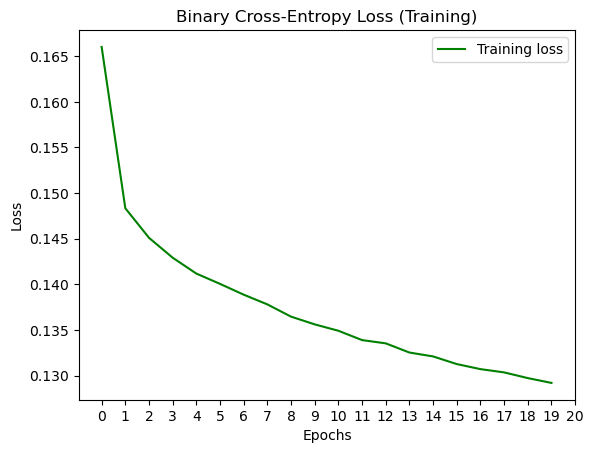

In [13]:
loss_train = model_history.history['loss']
epochs = range(0, number_of_epochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Binary Cross-Entropy Loss (Training)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(0, number_of_epochs + 1, 1))
plt.show()

><h3>Accuracy (Training)</h3><br>

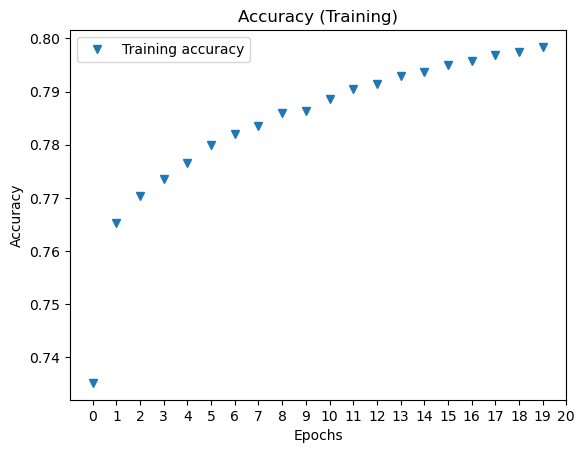

In [14]:
accuracy_train = model_history.history['accuracy']
epochs = range(0, number_of_epochs)
plt.plot(epochs, accuracy_train, 'v', label='Training accuracy')
plt.title('Accuracy (Training)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(np.arange(0, number_of_epochs + 1, 1))
plt.show()

>Method to create plot with the most used words per mental health disorder. <br> A <b>word cloud</b> is a data visualization technique that shows the most used words in a list given as input. If you wish to see the word cloud images make sure you set the variable <i>print_word_cloud_per_disorder</i> to <b>True</b>

In [15]:
def create_word_cloud(label):
    if print_word_cloud_per_disorder:
        features = " ".join(review for review in tfidf_vectorizer.processed_dataframe.loc[tfidf_vectorizer.processed_dataframe['mental_health_disorder'] == label].text)
        features = ' '.join(np.unique(features).tolist())
        wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords=english_stop_words).generate(
            features) 
        plt.figure(figsize=[20, 10])
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

<br><br>Using <b>Word Cloud</b> to present the features of the TF-IDF model

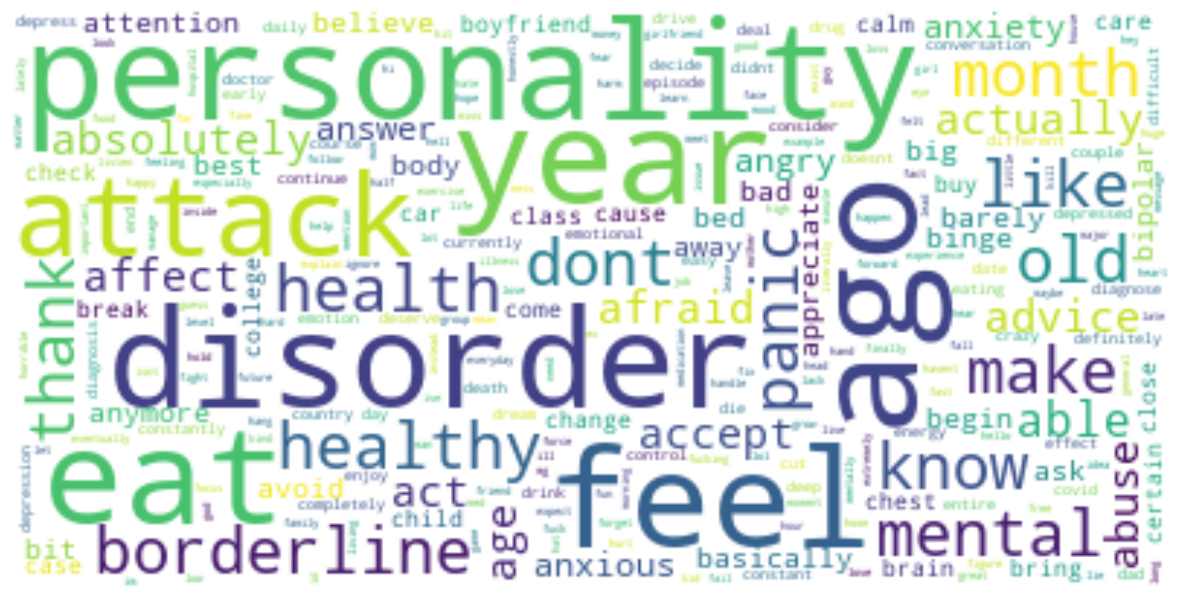

In [16]:
features = " ".join(review for review in tfidf_vectorizer.get_feature_names_out())
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white", stopwords=english_stop_words).generate(
    features)
plt.figure(figsize=[15, 12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h3> ANXIETY DISORDER </h3>

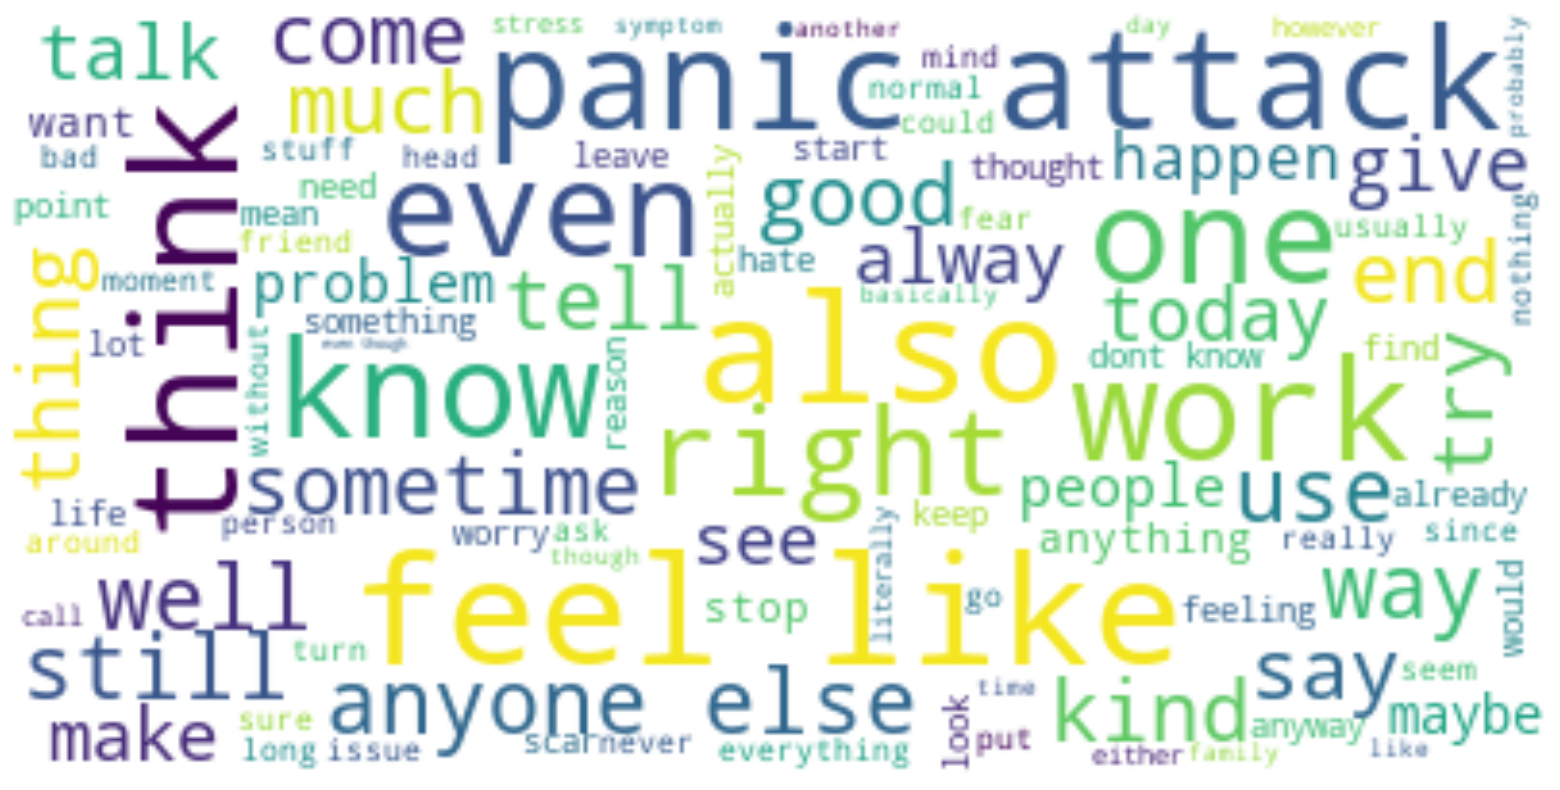

In [17]:
create_word_cloud('anxiety_disorder')

<h3> BIPOLAR DISORDER </h3>

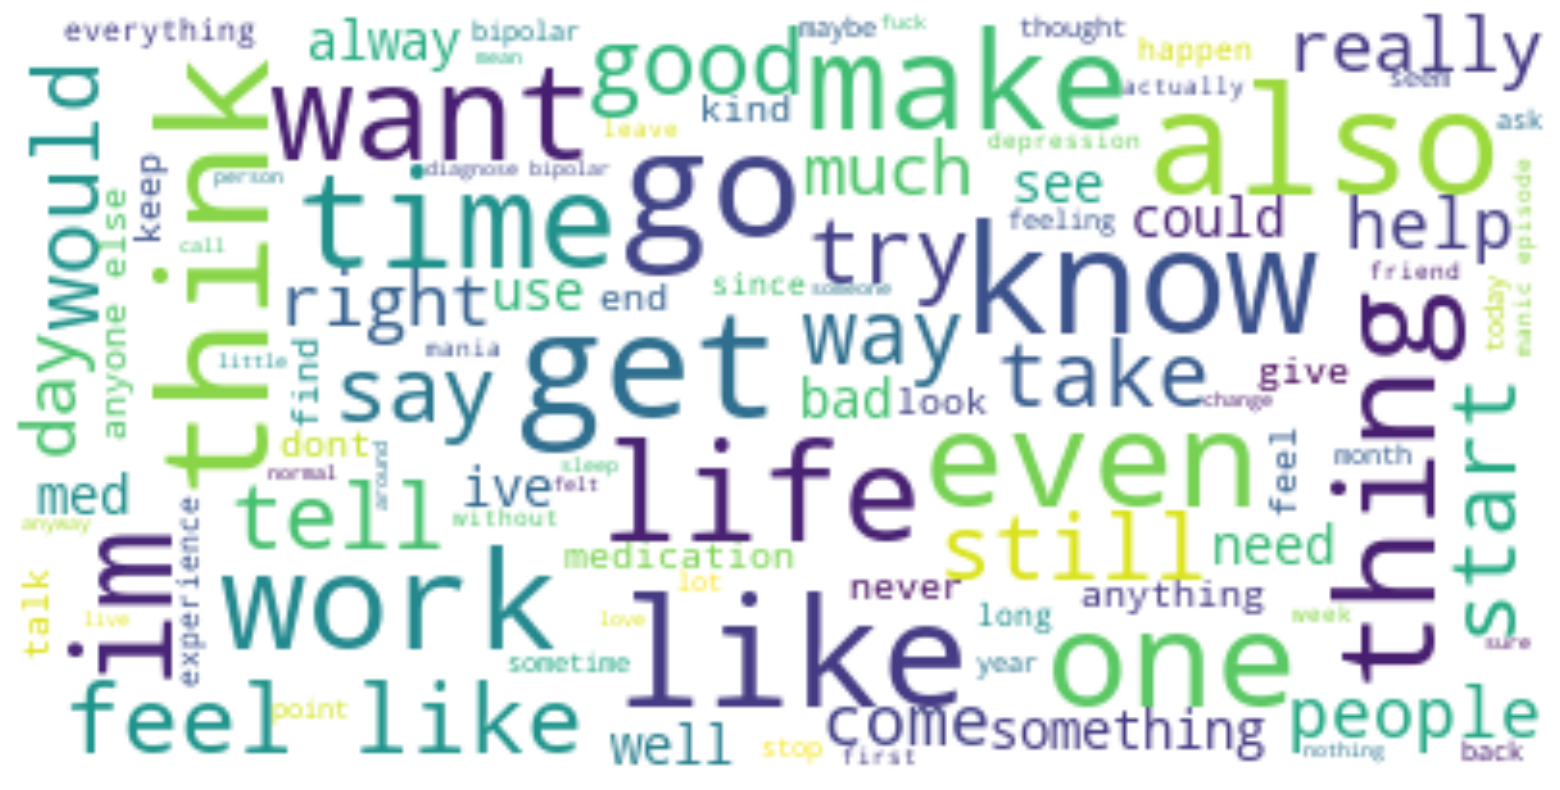

In [18]:
create_word_cloud('bipolar_disorder')

<h3> BORDERLINE PERSONALITY DISORDER </h3>

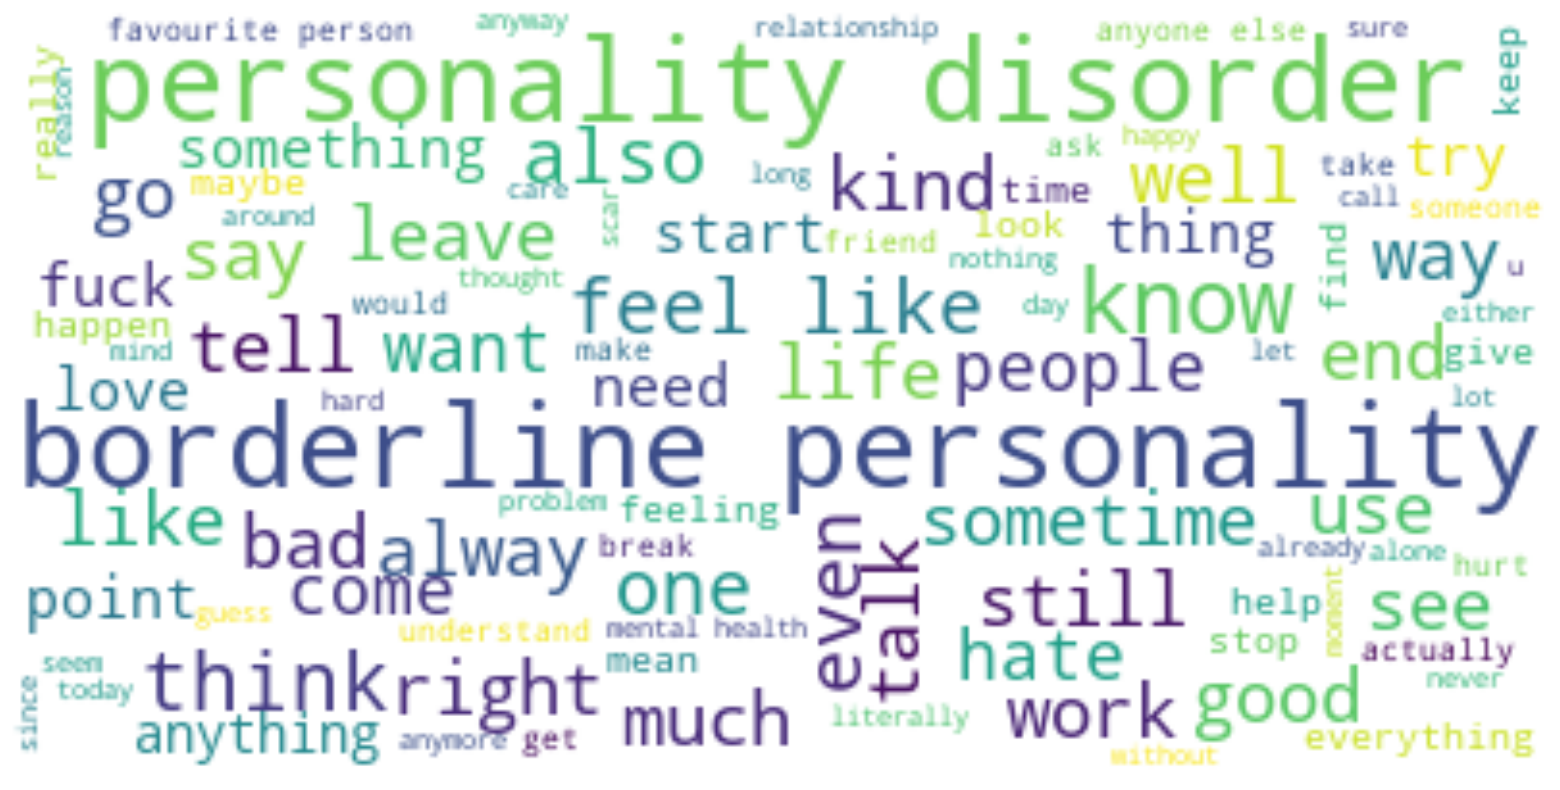

In [19]:
create_word_cloud('bpd_disorder')

<h3> DEPRESSION DISORDER </h3>

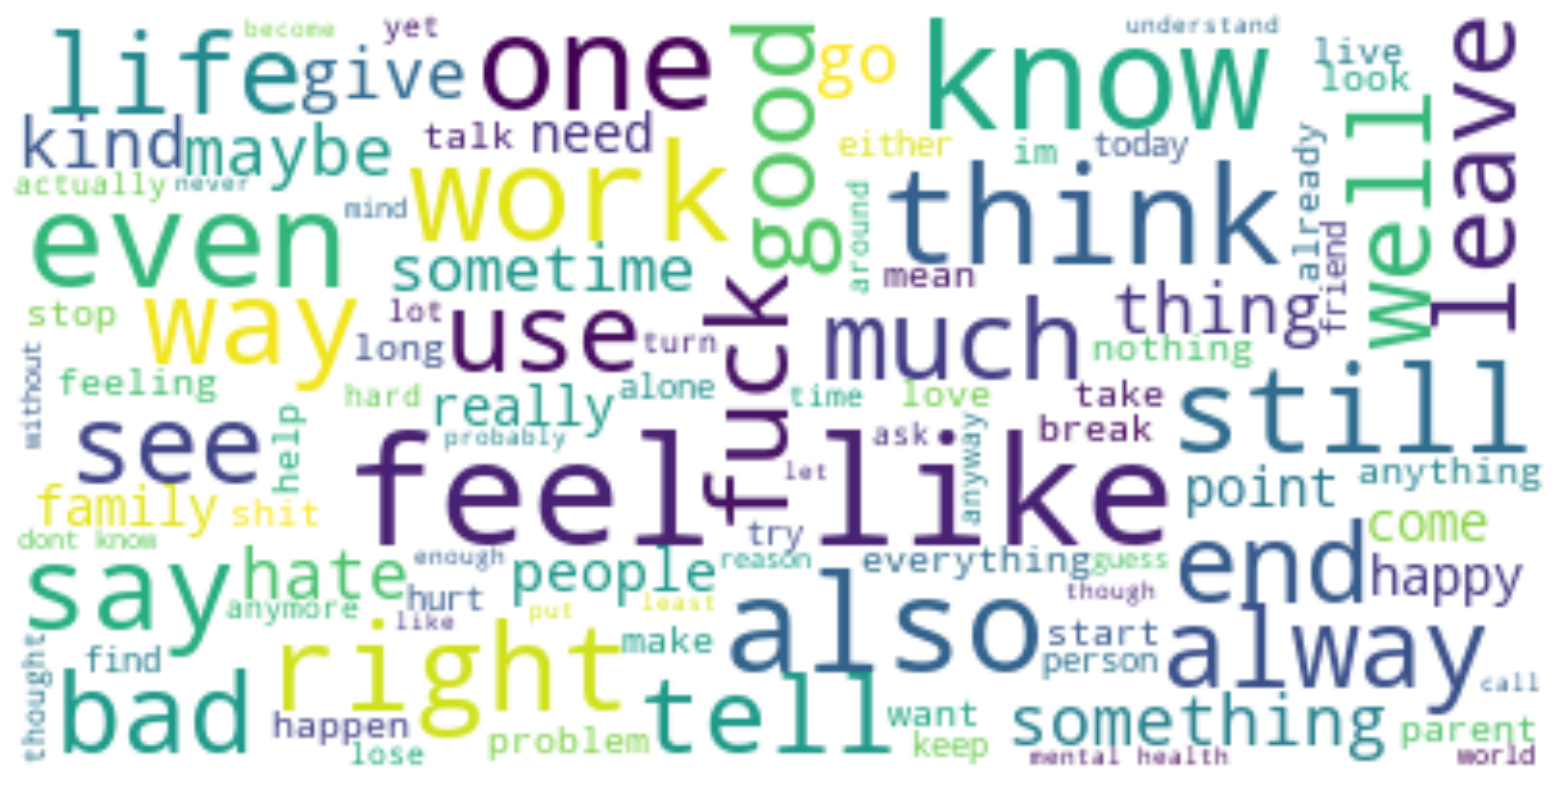

In [20]:
create_word_cloud('depression_disorder')

<h3> EATING DISORDER </h3>

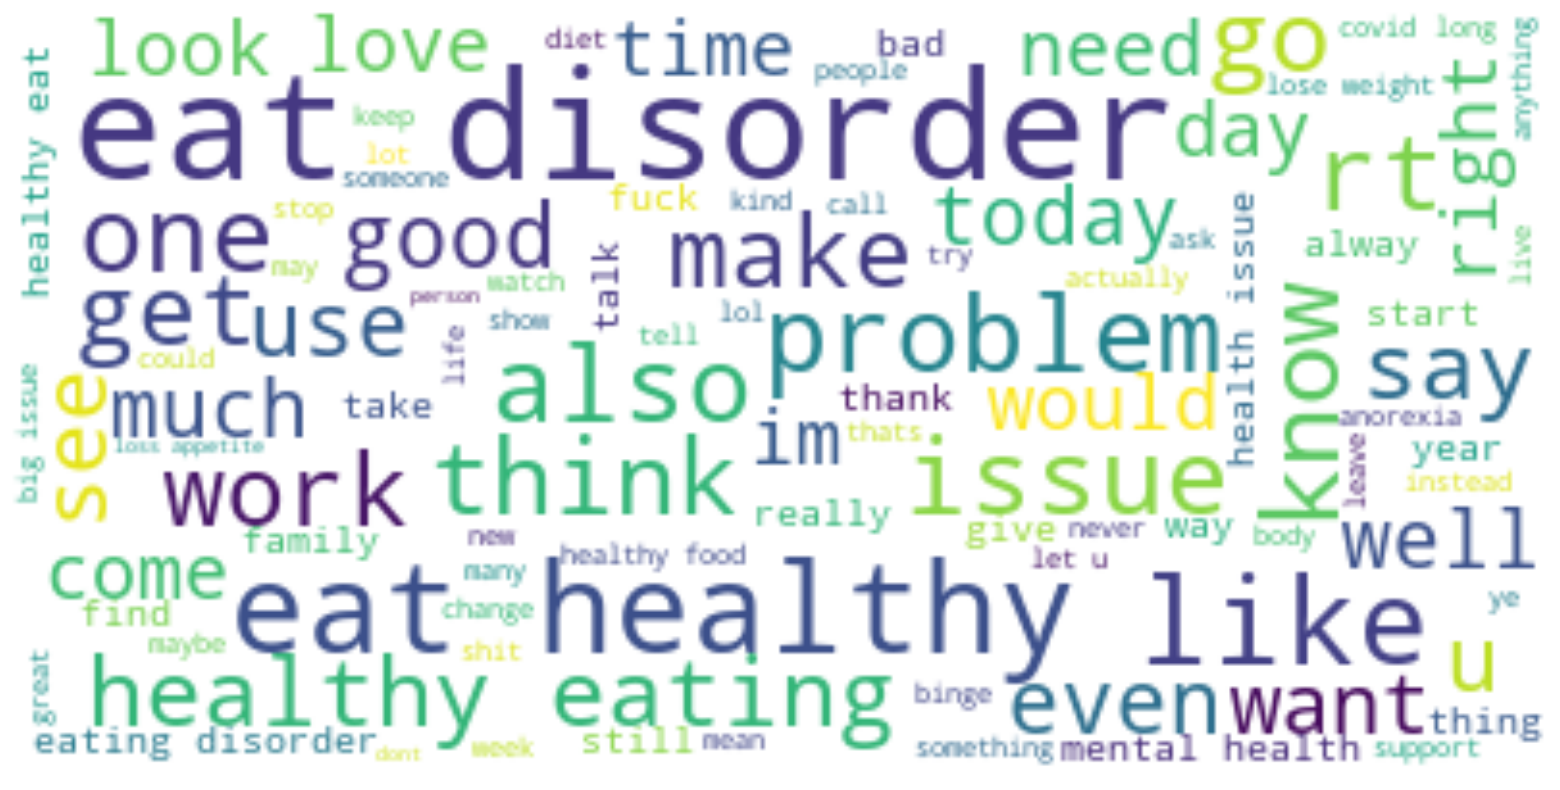

In [21]:
create_word_cloud('eating_disorder')

<h3> SCHIZOPHRENIA DISORDER </h3>

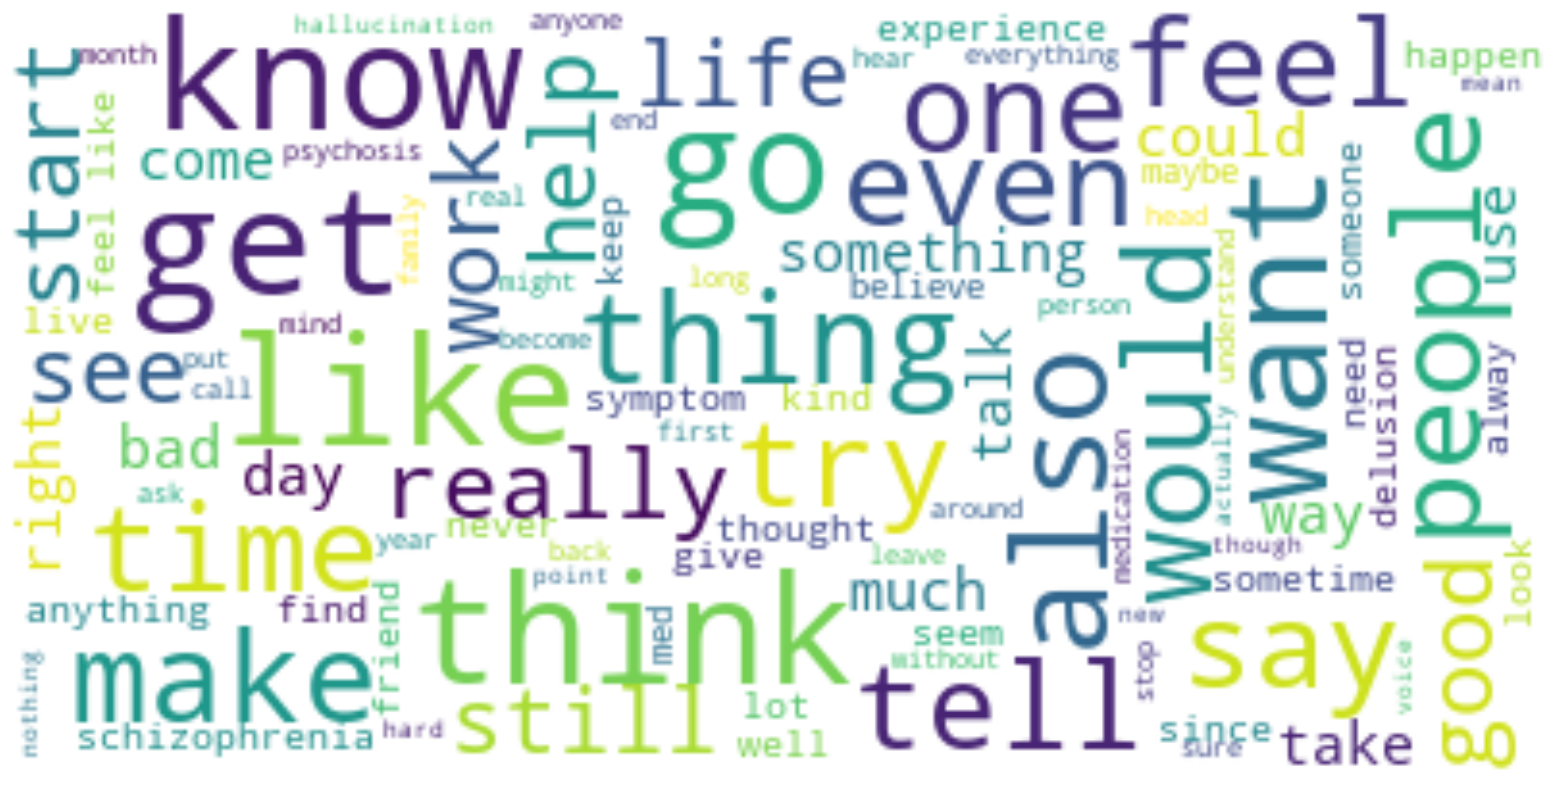

In [22]:
create_word_cloud('schizophrenia_disorder')

<h3> SEXUAL & GENDER IDENTITY DISORDER </h3>

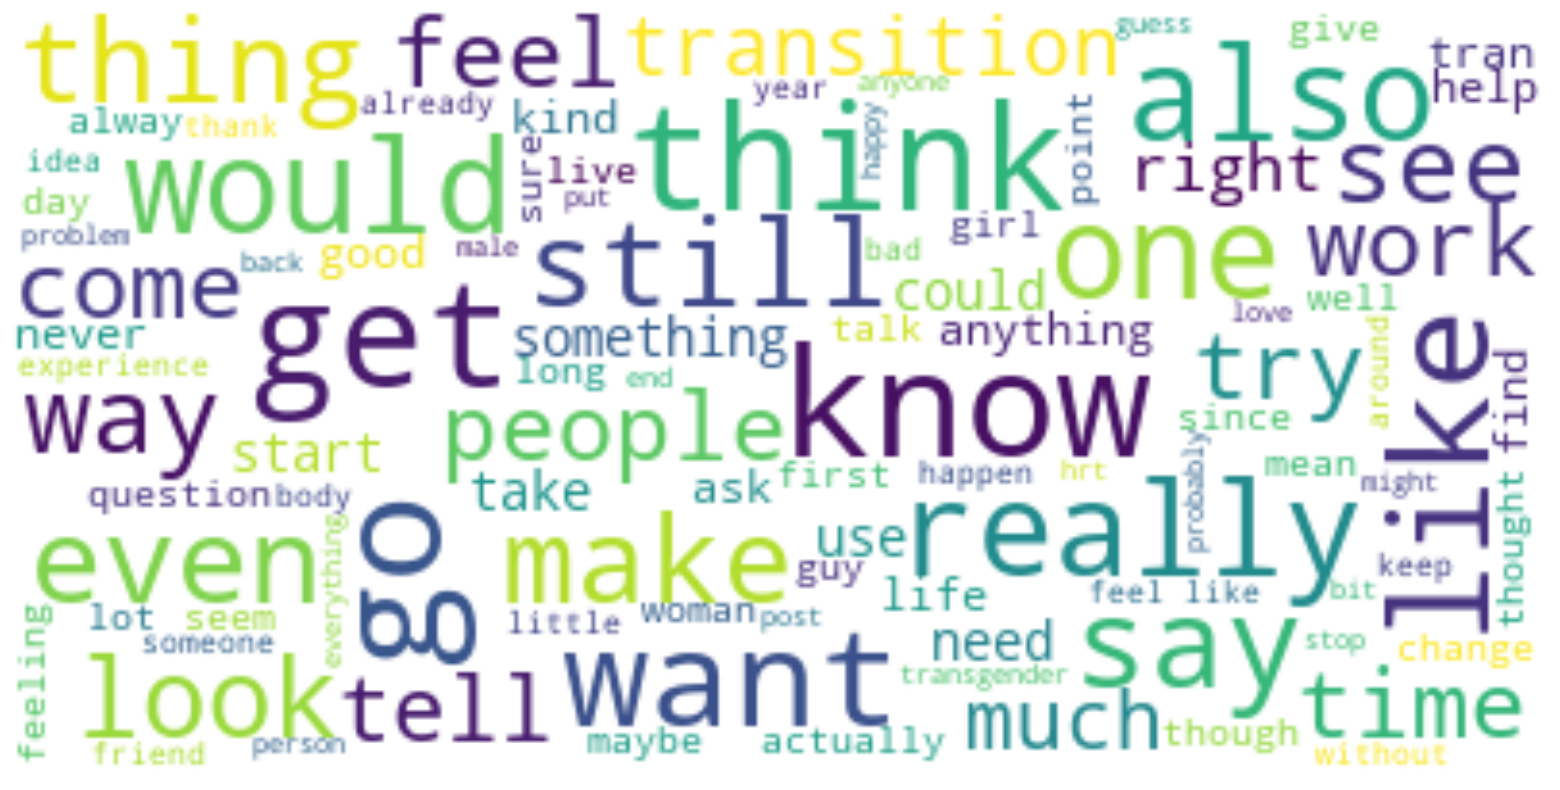

In [23]:
create_word_cloud('gender_dysphoria_disorder')

<h3> GENERAL MENTAL HEALTH DISORDER </h3>

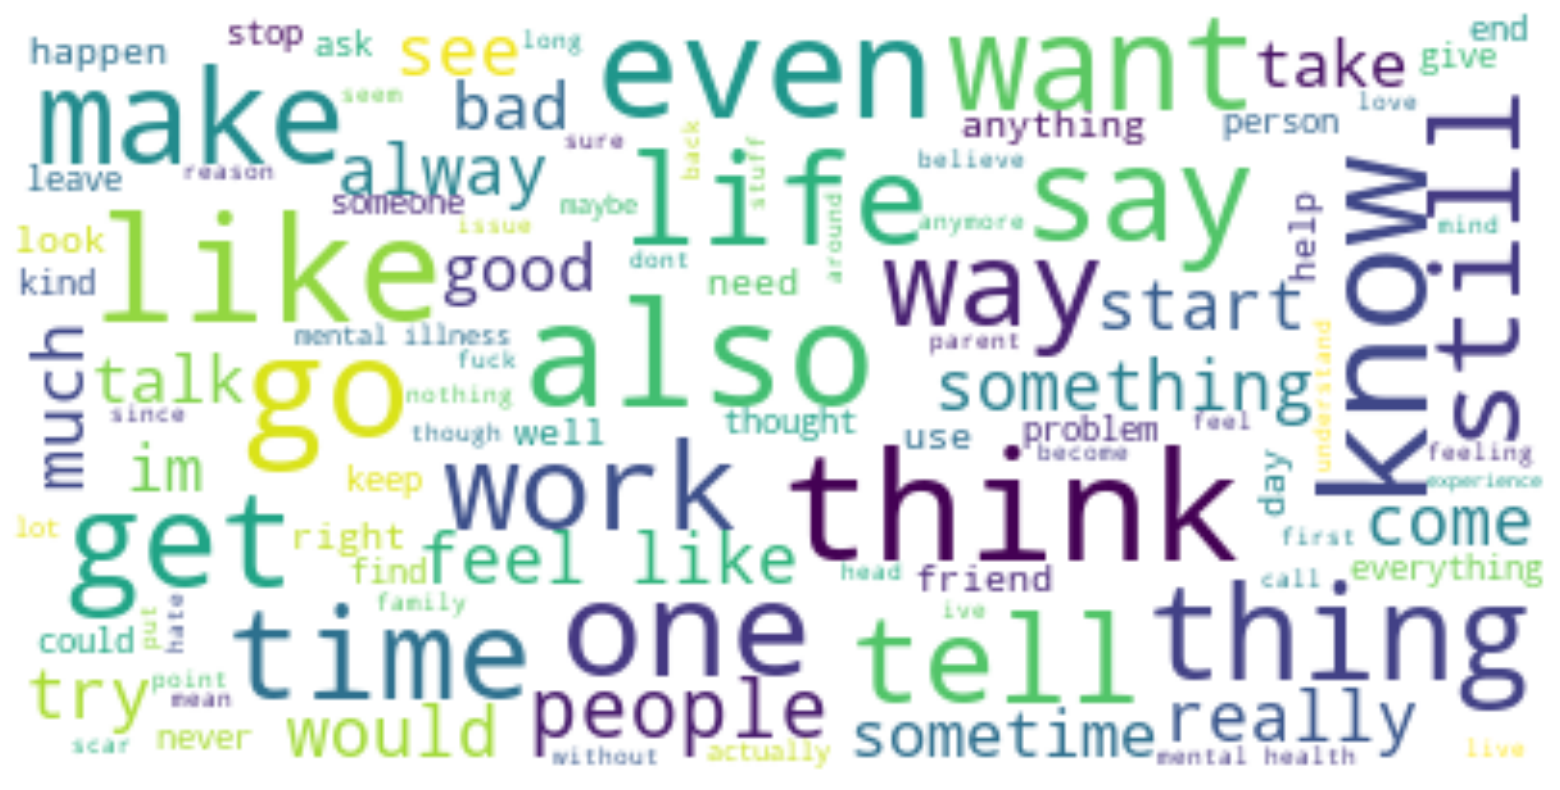

In [24]:
create_word_cloud('general_mental_disorder')

<br><center><h2> Graphs showing number of contexts per mental health disorder</h2></center>

In [25]:
def count_distribution(dataframe):
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=[18,6])
    ax = sns.countplot(data =  dataframe,
                  x = 'mental_health_disorder', 
                  palette = 'inferno',
                  order = dataframe['mental_health_disorder'].value_counts().index,
                  dodge = False)
    ax.bar_label(ax.containers[0])
    plt.title('Count Distribution', fontdict={'fontsize': 30, 'fontweight': 5, 'color': 'Black'})
    plt.xlabel("Mental Health Disorders")
    plt.ylabel("Total no. of Contexts")
    plt.show()

>Below you may find the number of samples per mental health disorder **before applying NLP processing techniques**.

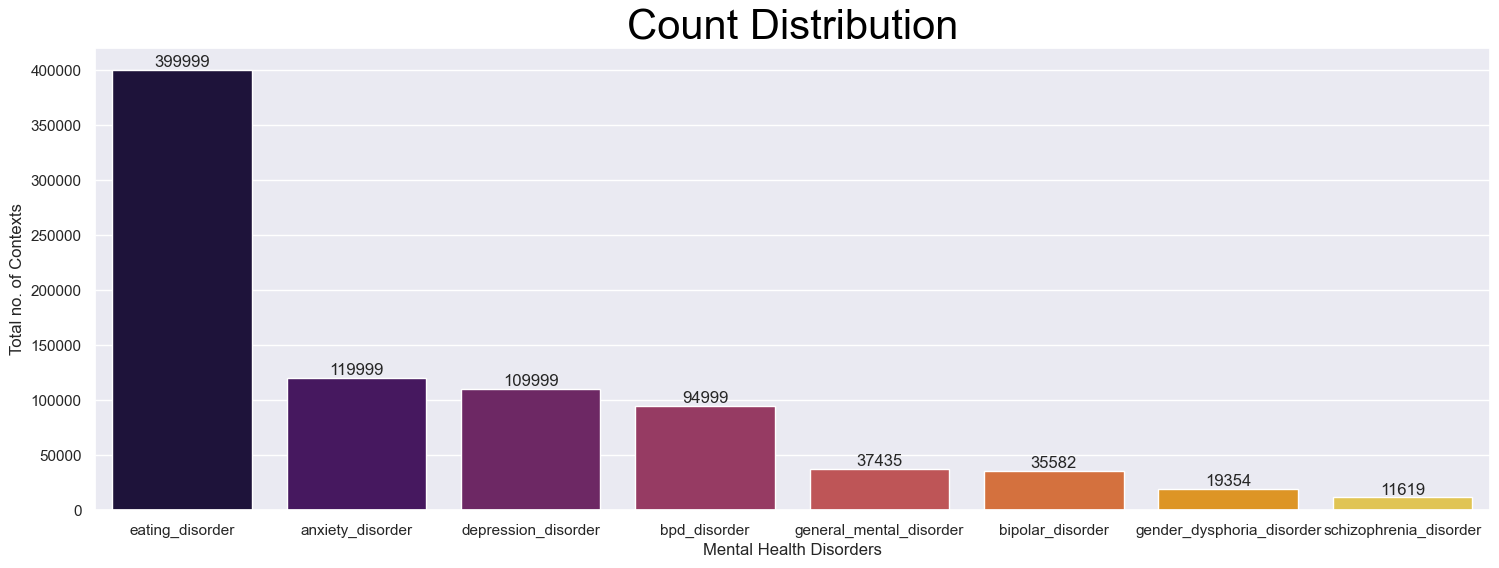

(828986, 2)

In [26]:
count_distribution(before_process_merged_dataframes)
before_process_merged_dataframes.shape

>Below you may find the number of samples per mental health disorder **after applying NLP processing techniques**.

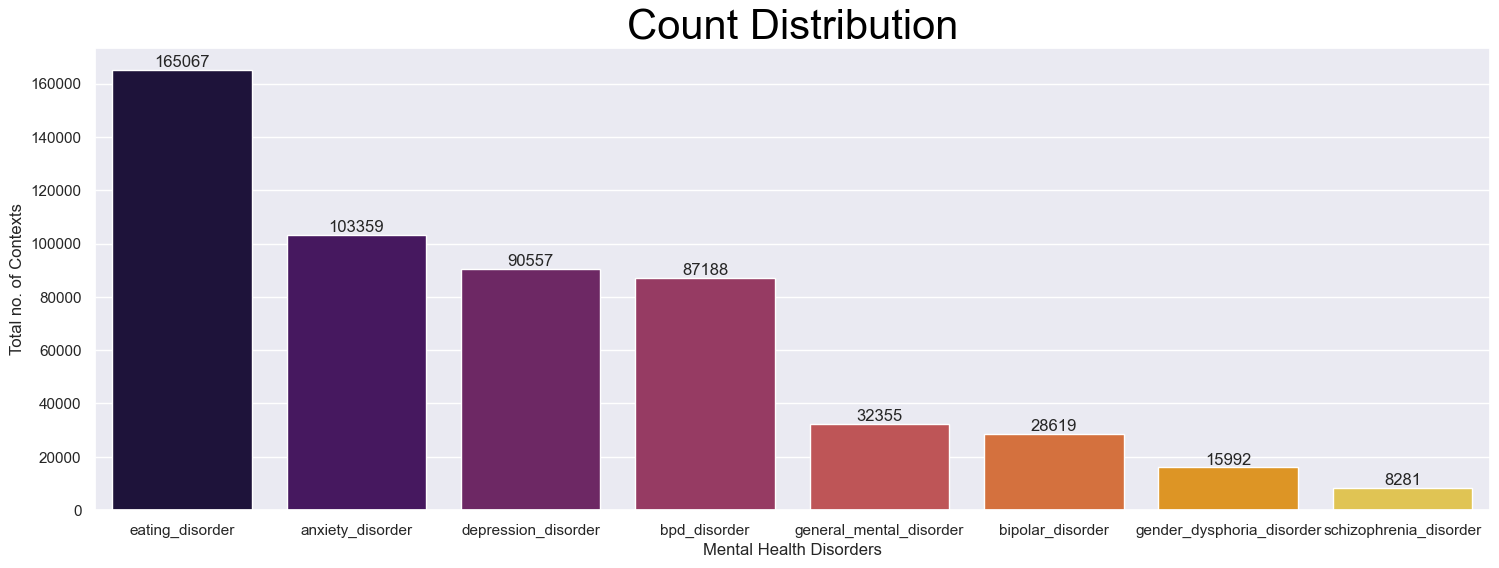

(531418, 2)

In [27]:
count_distribution(tfidf_vectorizer.processed_dataframe)
tfidf_vectorizer.processed_dataframe.shape

<br><br><center><h2> Additional reports</h2></center>

>Below you may find the top number of rows set (variable: "number_of_rows_to_print") of the TF-IDF's output. It includes all the features that have been identified including the frequencies of each feature.

In [28]:
display(pd.DataFrame(tfidf_vectorizer.samples_for_train_vectorized.round(3), 
                   columns=tfidf_vectorizer.get_feature_names_out()).head(number_of_rows_to_print))

able   absolutely  abuse  accept   act   actually  advice  affect  afraid  \
0   0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
1   0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
2   0.000      0.0      0.0    0.000  0.000    0.113     0.0     0.0     0.0    
3   0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
4   0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
5   0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
6   0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
7   0.159      0.0      0.0    0.000  0.195    0.000     0.0     0.0     0.0    
8   0.169      0.0      0.0    0.000  0.000    0.170     0.0     0.0     0.0    
9   0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
10  0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
11  0.000      0.0      0.0    0.000  0.000    0.317     0.0     0.0     0.0    
12  0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
13  0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
14  0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
15  0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
16  0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
17  0.000      0.0      0.0    0.234  0.000    0.000     0.0     0.0     0.0    
18  0.000      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    
19  0.114      0.0      0.0    0.000  0.000    0.000     0.0     0.0     0.0    

     age   ago  angry  answer  anxiety  anxious  anymore  appreciate   ask  \
0   0.000  0.0  0.000    0.0    0.230     0.0     0.00        0.0     0.00   
1   0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
2   0.000  0.0  0.145    0.0    0.000     0.0     0.00        0.0     0.00   
3   0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
4   0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
5   0.524  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
6   0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
7   0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.15   
8   0.000  0.0  0.000    0.0    0.128     0.0     0.00        0.0     0.00   
9   0.000  0.0  0.000    0.0    0.000     0.0     0.13        0.0     0.00   
10  0.000  0.0  0.000    0.0    0.274     0.0     0.00        0.0     0.00   
11  0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
12  0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
13  0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
14  0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
15  0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
16  0.000  0.0  0.000    0.0    0.267     0.0     0.00        0.0     0.00   
17  0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
18  0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   
19  0.000  0.0  0.000    0.0    0.000     0.0     0.00        0.0     0.00   

    attack  attention  avoid  away    bad   barely  basically   bed   begin  \
0     0.0     0.000     0.0   0.000  0.218    0.0      0.0     0.000  0.000   
1     0.0     0.000     0.0   0.000  0.000    0.0      0.0     0.000  0.000   
2     0.0     0.000     0.0   0.000  0.081    0.0      0.0     0.000  0.000   
3     0.0     0.000     0.0   0.000  0.000    0.0      0.0     0.000  0.000   
4     0.0     0.000     0.0   0.000  0.000    0.0      0.0     0.195  0.000   
5     0.0     0.000     0.0   0.000  0.000    0.0      0.0     0.000  0.000   
6     0.0     0.000     0.0   0.000  0.000    0.0      0.0     0.000  0.000   
7     0.0     0.000     0.0   0

>Below you may find a list of the binary classification matrix of the mental health disorders. This is the output after applying the same steps during the DL training model. The LabelEncoder converts the labels (string) to integer numbers (0-7) and then the second function ("np_utils") is used to convert integer numbers to binary class matrix. 

In [29]:
s_label_encoder = LabelEncoder()
s_label_encoder.fit(tfidf_vectorizer.processed_dataframe["mental_health_disorder"].unique())
test = tfidf_vectorizer.processed_dataframe["mental_health_disorder"].unique()
test = s_label_encoder.transform(test)
test = np_utils.to_categorical(test, number_of_classes)
display(pd.DataFrame(test.astype(int), columns = s_label_encoder.classes_))

anxiety_disorder  bipolar_disorder  bpd_disorder  depression_disorder  \
0          0                 0               1                0            
1          1                 0               0                0            
2          0                 1               0                0            
3          0                 0               0                1            
4          0                 0               0                0            
5          0                 0               0                0            
6          0                 0               0                0            
7          0                 0               0                0            

   eating_disorder  gender_dysphoria_disorder  general_mental_disorder  \
0         0                     0                         0              
1         0                     0                         0              
2         0                     0                         0              
3         0                     0                         0              
4         1                     0                         0              
5         0                     0                         1              
6         0                     0                         0              
7         0                     1                         0              

   schizophrenia_disorder  
0             0            
1             0            
2             0            
3             0            
4             0            
5             0            
6             1            
7             0

>Below you may find some samples classified with the relevant labels (classes). 

In [30]:
def print_samples_with_labels(samples, results):
    i = 0
    for index, value in samples.iteritems():
        if i <= number_of_rows_to_print:
            print('\n\033[1m' + "Sample: " '\033[0m\n')
            print(merged_dataframes['text'][index])
            print('\n\033[1m' + "This is labelled as: " + str(results[i]) + '\033[0m\n')
            print('\n**********************************************************************')
            i += 1


print('\n\n\033[1m' + 'Original training samples with multi-class prediction results'.center(100) + '\033[0m\n\n')
print_samples_with_labels(tfidf_vectorizer.samples_for_train, results[4])


print('\n\n\n\n\033[1m' + 'Original testing samples with multi-class prediction results'.center(100) + '\033[0m\n\n')
print_samples_with_labels(tfidf_vectorizer.samples_for_test, results[5])



                   Original training samples with multi-class prediction results                    



Sample: 

So Iâ€™ve had this anxiety of being sick somehow all my head and neck issues I was having over the span of the last two years has made me go to a hospital in Tennessee multiple times and almost every time they ct scanned me. Resulting in about 35 scans on just my head and neck alone. Now Iâ€™m having bad anxiety that I will have brain cancer or something because of all these unnecessary scans when they could have just did mris the whole time.. thoughts?

This is labelled as: ['anxiety_disorder']


**********************************************************************

Sample: 

I was just wondering if this was just a me thing or if this was a more common experience. It’s never enough to break skin or even leave any lasting marks I just do it cuz it makes me feel better in the moment. Sorry if this is triggering for anyone I didn’t know where else to go to talk abt this

T





                    Original testing samples with multi-class prediction results                    



Sample: 

Last week I had a very bad bladder infection but I stil lead on my boyfriend, when he asked whether or not it would hurt me I lied and said it won't. It hurt so badly I ended up crying, but I somehow told myself to just get over it as sex = intimacy. I hate myself for this because it's not like he doesn't tell me he loves me. Why do I need to hurt myself like this.

This is labelled as: ['bpd_disorder']


**********************************************************************

Sample: 

I had cancer two years ago but still have traumas, suddenly became hypochondriac, I see any new dicease or any famous person with a rare disease then i search on Google the symptoms and some days later I'm in panic because I think I could be ill with that rare disease

This is labelled as: ['anxiety_disorder', 'bpd_disorder', 'eating_disorder']


******************************************

<BarContainer object of 15 artists>

<Figure size 640x480 with 0 Axes>

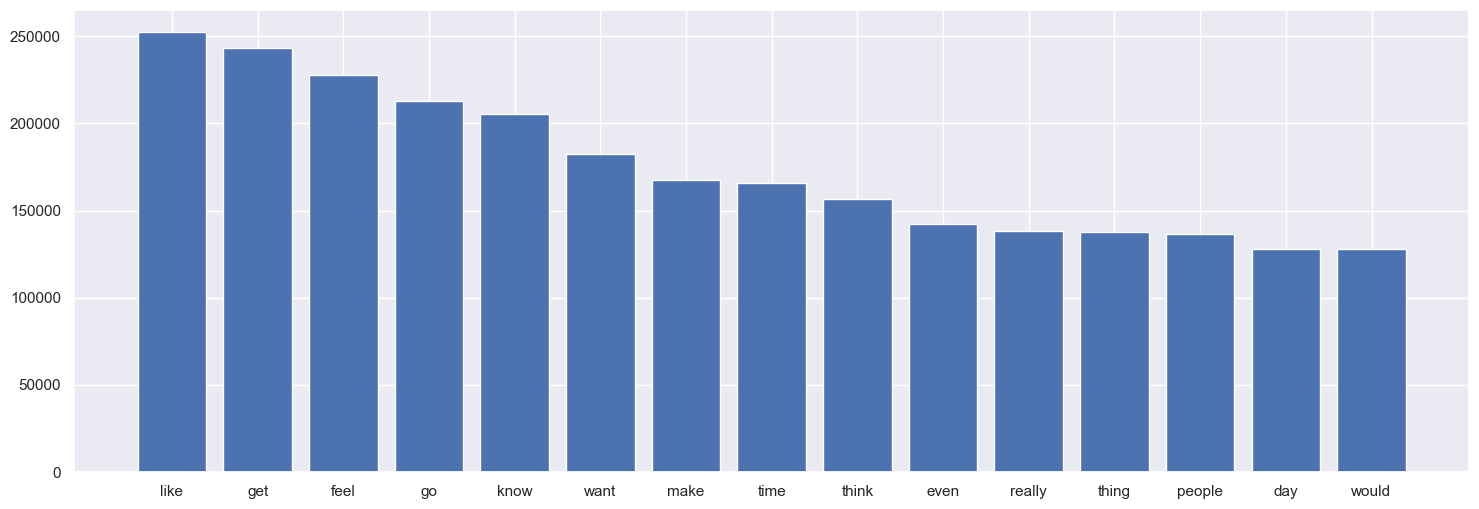

In [31]:
plt.clf()
english_stop_words = stopwords.words('english')
txt = ' '.join(tfidf_vectorizer.processed_dataframe['text'])
words = nltk.tokenize.word_tokenize(txt)
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in english_stop_words) 

rslt = pd.DataFrame(words_except_stop_dist.most_common(15),
                    columns=['Word', 'Frequency'])

plt.tight_layout()
plt.figure(figsize=[18,6])
plt.bar(rslt['Word'], rslt['Frequency'])